In [1]:
from crossflow.tasks import SubprocessTask
from crossflow.clients import Client
from crossflow.filehandling import FileHandler
from dask_jobqueue import SLURMCluster
from distributed import as_completed, wait

cluster = SLURMCluster(cores=1, 
                       job_cpu=1,
                       processes=1,
                       memory='256GB',
                       queue='standard',
                       job_directives_skip=['--mem', '-n '],
                       interface='hsn0',
                       job_extra_directives=['--nodes=1', 
                           '--qos=reservation',
                           '--reservation=e280-workshop_1018917',
                           '--tasks-per-node=128'],
                       python='python',
                       account='e280-workshop',
                       walltime="06:00:00",
                       shebang="#!/bin/bash --login",
                       local_directory='$PWD',
                       job_script_prologue=['module use /work/e280/shared/hecbiosim-software/modules',
                                            'module load autodock-vina-1.2.5',
                                            'module load openbabel-3.1.1',
                                  'export OMP_NUM_THREADS=1',
                                  'source /work/e280/e280-workshop/yuyang/myenv/bin/activate'])

/work/e280/e280-workshop/yuyang/myenv/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41273 instead
  warnings.warn(


In [2]:
vina = SubprocessTask('vina --ligand lig.pdbqt --receptor receptor.pdbqt --config  config.conf --out output.dat')
vina.set_inputs(['lig.pdbqt', 'receptor.pdbqt', 'config.conf'])
vina.set_outputs(['output.dat'])

smi2pdbqt = SubprocessTask('obabel -:"{smiles}" -ismi -opdbqt -O x.pdbqt --gen3d')
smi2pdbqt.set_inputs(['smiles'])
smi2pdbqt.set_outputs(['x.pdbqt'])

g_sim = SubprocessTask('/work/e280/shared/GuacaMol/g_sim.py "{smiles}" /work/e280/shared/GuacaMol/g_data.pkl -n 10 > similars.smi')
g_sim.set_inputs(['smiles'])
g_sim.set_outputs(['similars.smi'])

In [3]:
fh = FileHandler()
receptor = fh.load('3atl_receptor.pdbqt')
config = fh.load('3atl.conf')
vina.set_constant('receptor.pdbqt', receptor)
vina.set_constant('config.conf', config)

In [4]:
def extract_score(future):
    wait(future) # Wait for the job to end
    if future.status == 'finished': # This status means the job ran OK
    # The docking score appears in the file immediately after the string "RESULT":
        words = future.result().read_text().split()
        for i in range(len(words) - 1):
            if words[i] == 'RESULT:':
                return float(words[i+1])
    else: # if something has gone wrong, just return a large, bad, score
        return 1000.0

In [5]:
# Processing the docking results
cluster.scale(4) # 4 workers will do for now - we can explore this later
client = Client(cluster)
results = {} # An empty dictionary, ready to store docking results
lead_molecule = "CC(=O)Oc1ccccc1" # phenyl acetate
lead_pdbqt = client.submit(smi2pdbqt, lead_molecule) # convert from SMILES to pdbqt
dock = client.submit(vina, lead_pdbqt) # Dock it
results[lead_molecule] = extract_score(dock) # Extract the docking score and store
print(results)

{'CC(=O)Oc1ccccc1': -4.701}


In [6]:
# Test the workflow components
similars = client.submit(g_sim, lead_molecule)
similar_smis = similars.result().read_text().split('\n')[:-1]
new_candidates = []
for s in similar_smis:
    if not s in results:
        new_candidates.append(s)
print(new_candidates)

['O=C(Oc1ccccc1)C(=O)Oc1ccccc1', 'O=C(Oc1ccccc1)Oc1ccccc1', 'C=C(C)C(=O)Oc1ccccc1', 'NC(=O)Oc1ccccc1', 'CN(C)C(=O)Oc1ccccc1', 'CNC(=O)Oc1ccccc1', 'O=CC(=O)Oc1ccccc1', 'CC(=O)Oc1ccc(C(=O)c2ccccc2)cc1', 'O=C(Oc1ccccc1)P(=O)(O)O']


## Run the full workflow

In [7]:
icycle = 1
while len(new_candidates) > 0:
    print(f'Cycle {icycle}: docking {len(new_candidates)} candidates')
    # Convert the ligands to pdbqt format and dock, all in parallel:
    pdbqts = client.map(smi2pdbqt, new_candidates)
    dock_results = client.map(vina, pdbqts)
    # As the docking results come through, extract the scores data:
    for f in as_completed(dock_results):
        k = dock_results.index(f)
        results[new_candidates[k]] = extract_score(f)
    # Sort the dictionary of results so the best (most negative) score is first:
    results = {k:v for k,v in sorted(results.items(), key=lambda item: item[1])}
    lead_molecule = list(results.keys())[0]
    print(f'Current lead molecule: {lead_molecule}, docking score: {results[lead_molecule]}')
    # Find similar molecules:
    similars = client.submit(g_sim, lead_molecule)
    similar_smis = similars.result().read_text().split('\n')[:-1]
    new_candidates = []
    for s in similar_smis:
        if not s in results:
            new_candidates.append(s)
    if len(new_candidates) == 0:
        print('No new candidates, search completed')
    icycle += 1

Cycle 1: docking 9 candidates
Current lead molecule: O=C(Oc1ccccc1)Oc1ccccc1, docking score: -5.718
Cycle 2: docking 2 candidates
Current lead molecule: O=C(Oc1ccccc1)c1ccccc1, docking score: -5.861
Cycle 3: docking 9 candidates
Current lead molecule: O=C(Oc1cccc(O)c1)c1ccccc1, docking score: -6.673
Cycle 4: docking 8 candidates
Current lead molecule: COc1cccc(C(=O)Oc2cccc(O)c2)c1, docking score: -6.879
Cycle 5: docking 7 candidates
Current lead molecule: COc1cccc(C(=O)Oc2cccc(O)c2)c1, docking score: -6.879
No new candidates, search completed


In [8]:
optimum_pdbqt = client.submit(smi2pdbqt, lead_molecule)
dock_pose = client.submit(vina, optimum_pdbqt)
dock_pose.result().save('optimised_ligand.pdbqt')

'optimised_ligand.pdbqt'

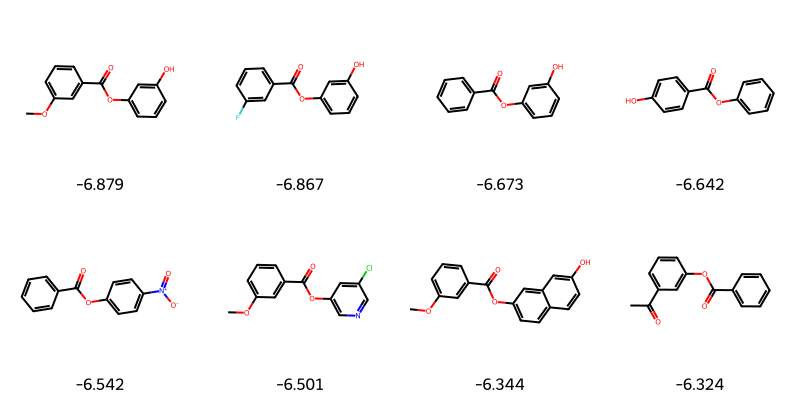

In [9]:
from rdkit import Chem
from rdkit.Chem import Draw

top_8 = list(results.keys())[:8] # Best 8 ligands - you could change this
# Convert to RDKit molecule objects:
ms = [Chem.MolFromSmiles(k) for k in top_8]
# Create an image of them showing structure and docking score:
img=Draw.MolsToGridImage(ms, molsPerRow=4, subImgSize=(200,200), legends=[str(results[k]) for k in top_8])
img